In [1]:
import cv2
import numpy as np
import itertools
import matplotlib.pyplot as plt

In [2]:
IMG_DIR = './Images/'
NUM_IMG = 40

im_list = []
for i in range(NUM_IMG):
    if i < 9:
        im_path = IMG_DIR + 'i0' + str(i+1) + '.jpg'
    else:
        im_path = IMG_DIR + 'i' + str(i+1) + '.jpg'
    im = cv2.imread(im_path)
    # print(type(im))
    im_list.append(im)



In [3]:
### Step 1: Color Distance


### Calculate color histogram for all input images, based on bin values: [3, 4, 5, 6, 7, 8, 9, 10]
hist_list = {}

n_bins_list = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]

for n_bins in n_bins_list:
    bins = np.linspace(0, 256, n_bins + 1, endpoint = True)
    hist_tmp = []
    for i in range(NUM_IMG):
        im_tmp = im_list[i].copy()
        assert isinstance(im_tmp, np.ndarray)
        
        bins_id = {key: idx for idx, key in enumerate(itertools.product(np.arange(n_bins), repeat = 3))}
        hist = np.zeros(n_bins ** 3)
        for id in range(len(bins) - 1):
            im_tmp[(im_list[i] >= bins[id]) & (im_list[i] < bins[id+1])] = id
        for h in range(im_tmp.shape[0]):
            for w in range(im_tmp.shape[1]):
                hist[bins_id[tuple(im_tmp[h, w])]] += 1
        hist_tmp.append(hist)
    hist_list[str(n_bins)] = hist_tmp

In [4]:
### Generate L1 distance, score board, and closest three list for each bin value
dist_matrix_list = {}
score_board_list = {}
closest_three_list = {}
for n_bins in n_bins_list:
    hist_list_n_bins = hist_list[str(n_bins)]
    dist_matrix = np.zeros([NUM_IMG, NUM_IMG])
    score_board = np.zeros([NUM_IMG, NUM_IMG])
    closest_three = np.zeros([NUM_IMG, 3])
    for i in range(NUM_IMG):
        for j in range(NUM_IMG):
            if i != j:
                dist_matrix[i][j] = np.sum(np.abs(hist_list_n_bins[i] - hist_list_n_bins[j])) / (2 * 80 * 69)
    for i in range(NUM_IMG):
        ids = dist_matrix[i].argsort()[:4] # smallest is itself
        closest_three[i] = ids[1:4] + 1
        score_board[i][ids[1]] += 3
        score_board[i][ids[2]] += 2
        score_board[i][ids[3]] += 1
    dist_matrix_list[str(n_bins)] = dist_matrix.astype(np.float32)
    score_board_list[str(n_bins)] = score_board.astype(np.float32)
    closest_three_list[str(n_bins)] = closest_three.astype(np.int32)
    np.savetxt('./Output/dist_matrix_' + str(n_bins) + '.txt', dist_matrix, '%.2f')
    np.savetxt('./Output/score_board_' + str(n_bins) + '.txt', score_board, '%2d')
    np.savetxt('./Output/closest_three' + str(n_bins) + '.txt', closest_three, '%2d')

In [5]:
### Pick the best bin value, based on L1 distance between the Borda Count score board and standardized crowd.txt
crowd = np.loadtxt('./Crowd.txt', 'int')
num_valid_votes = (int)(np.sum(crowd) / 240)
crowd_std = crowd / num_valid_votes
l1_dist_list = np.zeros(len(n_bins_list))
id = 0
for n_bins in n_bins_list:
    l1_dist_list[id] = np.sum(np.abs(score_board_list[str(n_bins)] - crowd_std)) / (2 * 40 * 40)
    id += 1
print(l1_dist_list.argsort()[:1])
# Index 5 of the bins value list has smallest L1 distance, choose bin = 7

[5]


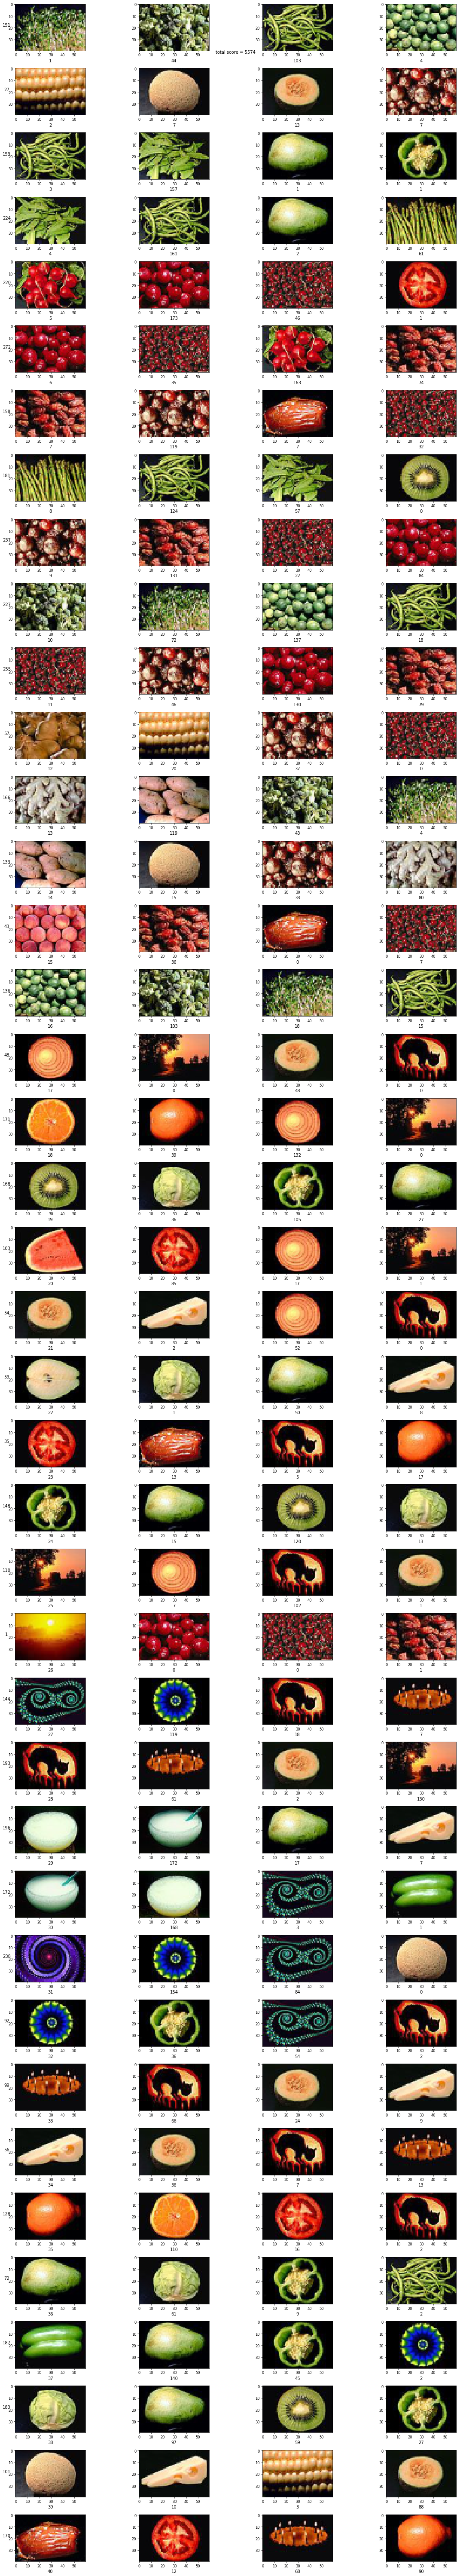

In [6]:
### Displaying the 40 rows of thumbnail figures with scores

color_final = closest_three_list[str(7)]
plt.close("all")
f, grid = plt.subplots(40, 4, figsize=(20, 100), dpi = 60)
col = 0
score_sum = 0
rows = []
for row in range(NUM_IMG):
    thumbnail = cv2.resize(im_list[row], (60,40))
    grid[row, 0].imshow(cv2.cvtColor(thumbnail, cv2.COLOR_BGR2RGB))
    grid[row, 0].set_xlabel(str(row + 1), fontsize = 12)
    score_q_sum = 0
    for i in range(3):
        id = color_final[row][i] - 1
        thumbnail = cv2.resize(im_list[id], (60,40))
        grid[row, i+1].imshow(cv2.cvtColor(thumbnail, cv2.COLOR_BGR2RGB))
        score = crowd[row][id]
        score_q_sum += score
        grid[row, i+1].set_xlabel(str(score), fontsize = 12)
    # grid[:,row].set_ylabel(str(score_q_sum))
    rows.append(score_q_sum)
    score_sum += score_q_sum
    
for ax, row in zip(grid[:,0], rows):
    ax.set_ylabel(row, rotation=0, size='large', fontsize = 12)
f.tight_layout()
f.suptitle("total score = " + str(score_sum))
f.savefig('./Output/color.png')

# Total score 5574


In [7]:
### Personal ground truth versus crowd
personal = np.loadtxt('./yh2825.txt', 'int')
personal_sum = 0
for i in range(NUM_IMG):
    personal_sum += crowd[i][personal[i][1] - 1] + crowd[i][personal[i][2] - 1] + crowd[i][personal[i][3] - 1]
    
print(personal_sum)

8543


In [8]:
### Personal ground truth versus the system
color_performance_count = 0
for i in range(NUM_IMG):
    color_performance_count += np.intersect1d(personal[i][1:4], color_final[i]).size
print(color_performance_count)

43


In [9]:
### Step 2: Texture Distance

# To grayscale
gray_im_list = []
for i in range(NUM_IMG):
    gray_im = np.zeros([60, 89])
    for j in range(60):
        for k in range(89):
            gray_im[j][k] = np.sum(im_list[i][j][k])/3
    gray_im_list.append(gray_im)

In [10]:
# Get Laplacian Image
lap_list = []
kernel = np.array([[-1, -1, -1],
                   [-1, 8, -1],
                   [-1, -1, -1]])
kernel = kernel / 9
for i in range(NUM_IMG):
    lap_im = cv2.filter2D(gray_im_list[i], -1, kernel)
    lap_im = np.abs(lap_im)
    lap_list.append(lap_im)


In [11]:
hist_list_2 = {}

n_bins_list_2 = np.arange(2,256)

for n_bins in n_bins_list_2:
    bins = np.linspace(0, 256, n_bins + 1, endpoint = True)
    hist_tmp = []
    for i in range(NUM_IMG):
        tmp = lap_list[i].copy()
        assert isinstance(tmp, np.ndarray)
        
        bins_id = np.arange(n_bins)
        hist = np.zeros(n_bins)
        for id in range(len(bins) - 1):
            tmp[(lap_list[i] >= bins[id]) & (lap_list[i] < bins[id+1])] = id
        for h in range(tmp.shape[0]):
            for w in range(tmp.shape[1]):
                hist[bins_id[int(tmp[h,w])]] += 1
        hist_tmp.append(hist)
    hist_list_2[str(n_bins)] = hist_tmp

In [12]:
dist_matrix_list_2 = {}
score_board_list_2 = {}
closest_three_list_2 = {}
for n_bins in n_bins_list_2:
    hist_list_n_bins_2 = hist_list_2[str(n_bins)]
    dist_matrix_2 = np.zeros([NUM_IMG, NUM_IMG])
    score_board_2 = np.zeros([NUM_IMG, NUM_IMG])
    closest_three_2 = np.zeros([NUM_IMG, 3])
    for i in range(NUM_IMG):
        for j in range(NUM_IMG):
            if i != j:
                dist_matrix_2[i][j] = np.sum(np.abs(hist_list_n_bins_2[i] - hist_list_n_bins_2[j])) / (2 * 80 * 69)
    for i in range(NUM_IMG):
        ids = dist_matrix_2[i].argsort()[:4] # smallest is itself
        closest_three_2[i] = ids[1:4] + 1
        score_board_2[i][ids[1]] += 3
        score_board_2[i][ids[2]] += 2
        score_board_2[i][ids[3]] += 1
    dist_matrix_list_2[str(n_bins)] = dist_matrix_2.astype(np.float32)
    score_board_list_2[str(n_bins)] = score_board_2.astype(np.float32)
    closest_three_list_2[str(n_bins)] = closest_three_2.astype(np.int32)
    # np.savetxt('./Output/dist_matrix_2_' + str(n_bins) + '.txt', dist_matrix_2, '%.2f')
    # np.savetxt('./Output/score_board_2_' + str(n_bins) + '.txt', score_board_2, '%2d')
    # np.savetxt('./Output/closest_three2_' + str(n_bins) + '.txt', closest_three_2, '%2d')

In [13]:
l1_dist_list_2 = np.zeros(len(n_bins_list_2))
id = 0
for n_bins in n_bins_list_2:
    l1_dist_list_2[id] = np.sum(np.abs(score_board_list_2[str(n_bins)] - crowd_std)) / (2 * 40 * 40)
    id += 1
print(l1_dist_list_2.argsort()[:1])
# Index 42 of the bins value list has smallest L1 distance, choose bin = 44

[42]


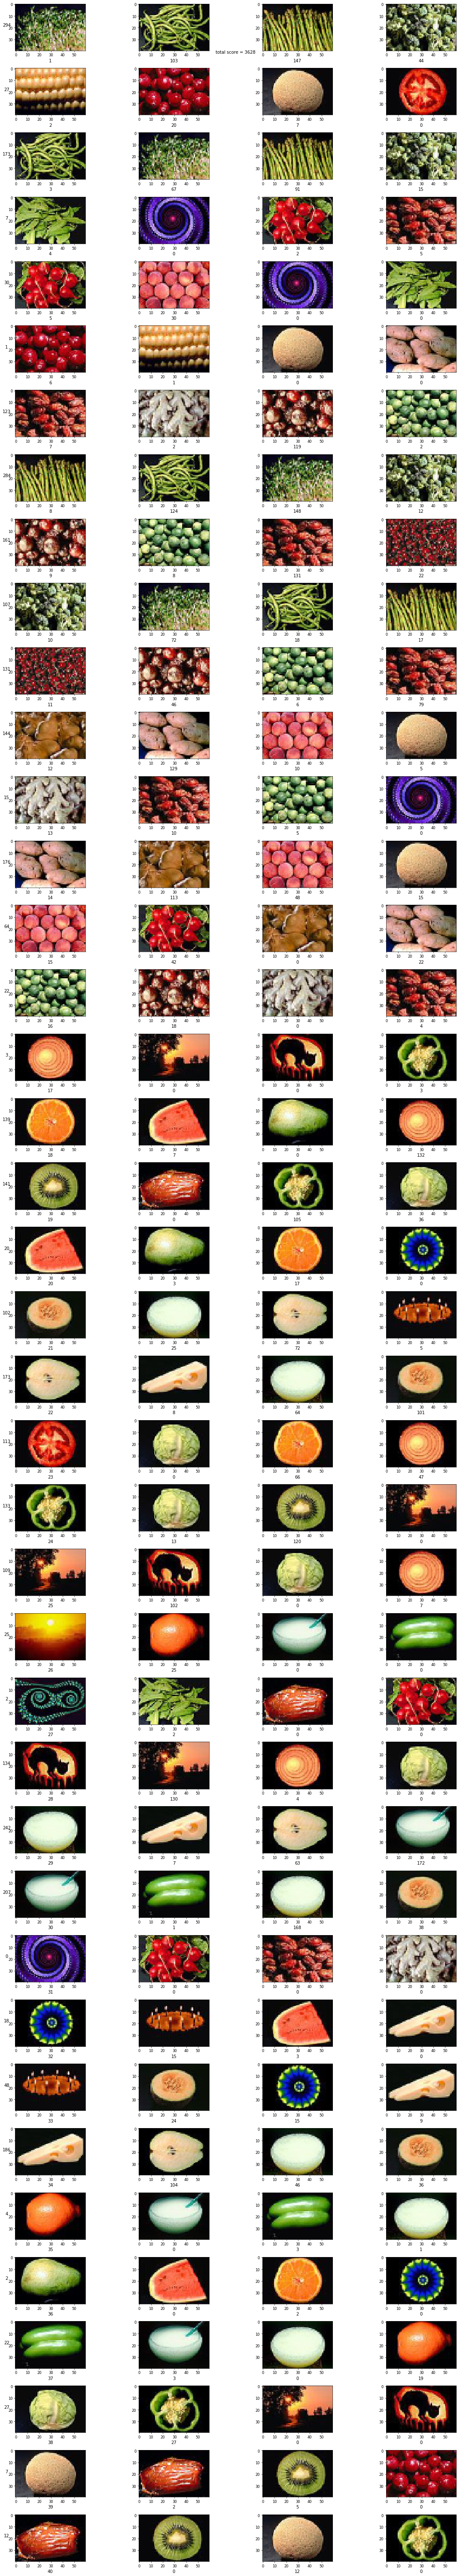

In [14]:
### Displaying the 40 rows of thumbnail figures with scores

texture_final = closest_three_list_2[str(44)]
plt.close("all")
f, grid = plt.subplots(40, 4, figsize=(20, 100), dpi = 60)
col = 0
score_sum = 0
rows = []
for row in range(NUM_IMG):
    thumbnail = cv2.resize(im_list[row], (60,40))
    grid[row, 0].imshow(cv2.cvtColor(thumbnail, cv2.COLOR_BGR2RGB))
    grid[row, 0].set_xlabel(str(row + 1), fontsize = 12)
    score_q_sum = 0
    for i in range(3):
        id = texture_final[row][i] - 1
        thumbnail = cv2.resize(im_list[id], (60,40))
        grid[row, i+1].imshow(cv2.cvtColor(thumbnail, cv2.COLOR_BGR2RGB))
        score = crowd[row][id]
        score_q_sum += score
        grid[row, i+1].set_xlabel(str(score), fontsize = 12)
    # grid[:,row].set_ylabel(str(score_q_sum))
    rows.append(score_q_sum)
    score_sum += score_q_sum
    
for ax, row in zip(grid[:,0], rows):
    ax.set_ylabel(row, rotation=0, size='large', fontsize = 12)
f.tight_layout()
f.suptitle("total score = " + str(score_sum))
f.savefig('./Output/texture.png')

# Total score 3638



In [15]:
np.savetxt('./Output/dist_matrix_2_' + str(n_bins) + '.txt', dist_matrix_list_2[str(47)], '%.2f')
np.savetxt('./Output/score_board_2_' + str(n_bins) + '.txt', score_board_list_2[str(47)], '%2d')
np.savetxt('./Output/closest_three2_' + str(n_bins) + '.txt', closest_three_list_2[str(47)], '%2d')

In [16]:
### Personal ground truth versus the system
texture_performance_count = 0
for i in range(NUM_IMG):
    texture_performance_count += np.intersect1d(personal[i][1:4], texture_final[i]).size
print(texture_performance_count)

28


In [17]:
### Step 3: Shape distance

BW_ = np.array([50, 50, 50])

bw_list = []
for i in range(NUM_IMG):
    bw_im = np.zeros([60, 89])
    for j in range(60):
        for k in range(89):
            if im_list[i][j][k][0] <= BW_[0] and im_list[i][j][k][1] <= BW_[1] and im_list[i][j][k][2] <= BW_[2]:
                bw_im[j][k] = 1
    bw_list.append(bw_im)


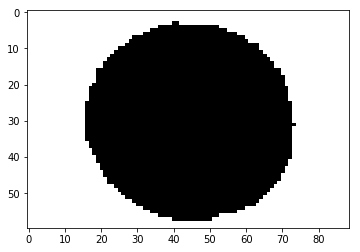

In [18]:
plt.imshow(bw_list[16], 'gray')

In [19]:
### Calculate shape distance matrix, Borda count matrix, and best three matches list
dist_matrix_3 = np.zeros([40, 40])
closest_three_3 = np.zeros([40, 3])
score_board_3 = np.zeros([40, 40])
for i in range(40):
    for j in range(40):
        count = 0
        for h in range(60):
            for w in range(89):
                if bw_list[i][h][w] != bw_list[j][h][w]:
                    count += 1
        dist_matrix_3[i][j] = count/(60*89)
        
for k in range(NUM_IMG):
    ids = dist_matrix_3[k].argsort()[:4] # smallest is itself
    closest_three_3[k] = ids[1:4] + 1
closest_three_3 = closest_three_3.astype(np.int32)


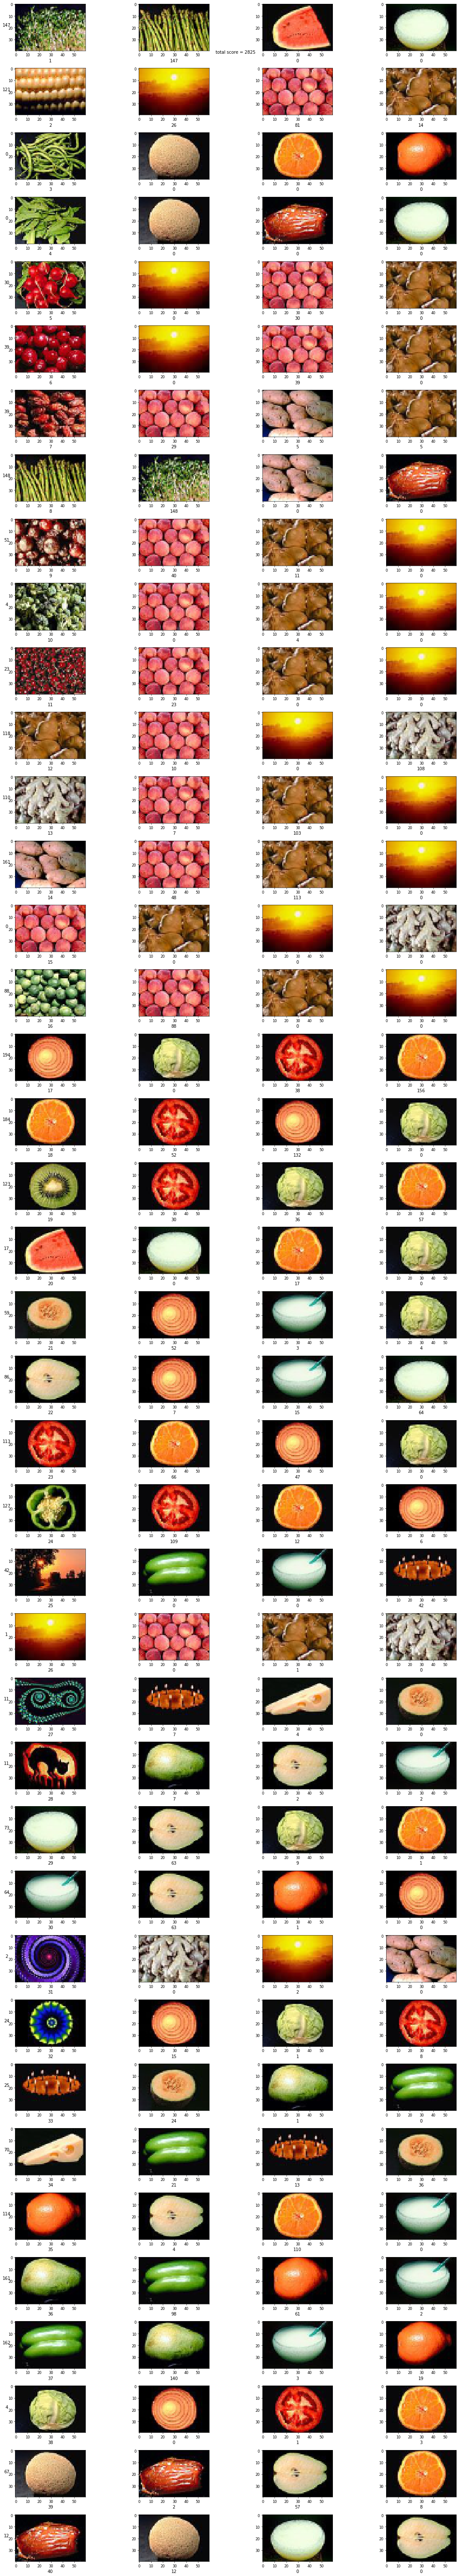

In [20]:
### Displaying the 40 rows of thumbnail figures with scores

shape_final = closest_three_3
plt.close("all")
f, grid = plt.subplots(40, 4, figsize=(20, 100), dpi = 60)
col = 0
score_sum = 0
rows = []
for row in range(NUM_IMG):
    thumbnail = cv2.resize(im_list[row], (60,40))
    grid[row, 0].imshow(cv2.cvtColor(thumbnail, cv2.COLOR_BGR2RGB))
    grid[row, 0].set_xlabel(str(row + 1), fontsize = 12)
    score_q_sum = 0
    for i in range(3):
        id = int(shape_final[row][i] - 1)
        thumbnail = cv2.resize(im_list[id], (60,40))
        grid[row, i+1].imshow(cv2.cvtColor(thumbnail, cv2.COLOR_BGR2RGB))
        score = crowd[row][id]
        score_q_sum += score
        grid[row, i+1].set_xlabel(str(score), fontsize = 12)
    # grid[:,row].set_ylabel(str(score_q_sum))
    rows.append(score_q_sum)
    score_sum += score_q_sum
    
for ax, row in zip(grid[:,0], rows):
    ax.set_ylabel(row, rotation=0, size='large', fontsize = 12)
f.tight_layout()
f.suptitle("total score = " + str(score_sum))
f.savefig('./Output/shape.png')

# Total score 2825

In [21]:
np.savetxt('./Output/dist_matrix_3_' + str(n_bins) + '.txt', dist_matrix_3, '%.2f')
np.savetxt('./Output/closest_three_3_' + str(n_bins) + '.txt', closest_three_3, '%2d')

In [22]:
### Personal ground truth versus the system
shape_performance_count = 0
for i in range(NUM_IMG):
    shape_performance_count += np.intersect1d(personal[i][1:4], shape_final[i]).size
print(shape_performance_count)

26


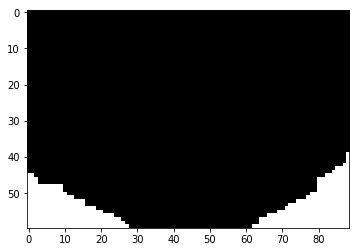

In [23]:
plt.imshow(bw_list[25], 'gray')

In [27]:
### Step 4: Overall distance
borda_count = [5574, 3638, 2825]
weights = borda_count / np.sum(borda_count)
overall_distance_matrix = weights[0] * dist_matrix_list[str(7)] + weights[1] * dist_matrix_list_2[str(44)] + weights[2] * dist_matrix_3

closest_three_overall = np.zeros([40, 3])
for k in range(NUM_IMG):
    ids = overall_distance_matrix[k].argsort()[:4] # smallest is itself
    closest_three_overall[k] = ids[1:4] + 1
closest_three_overall = closest_three_overall.astype(np.int32)

[0.46307219 0.30223478 0.23469303]


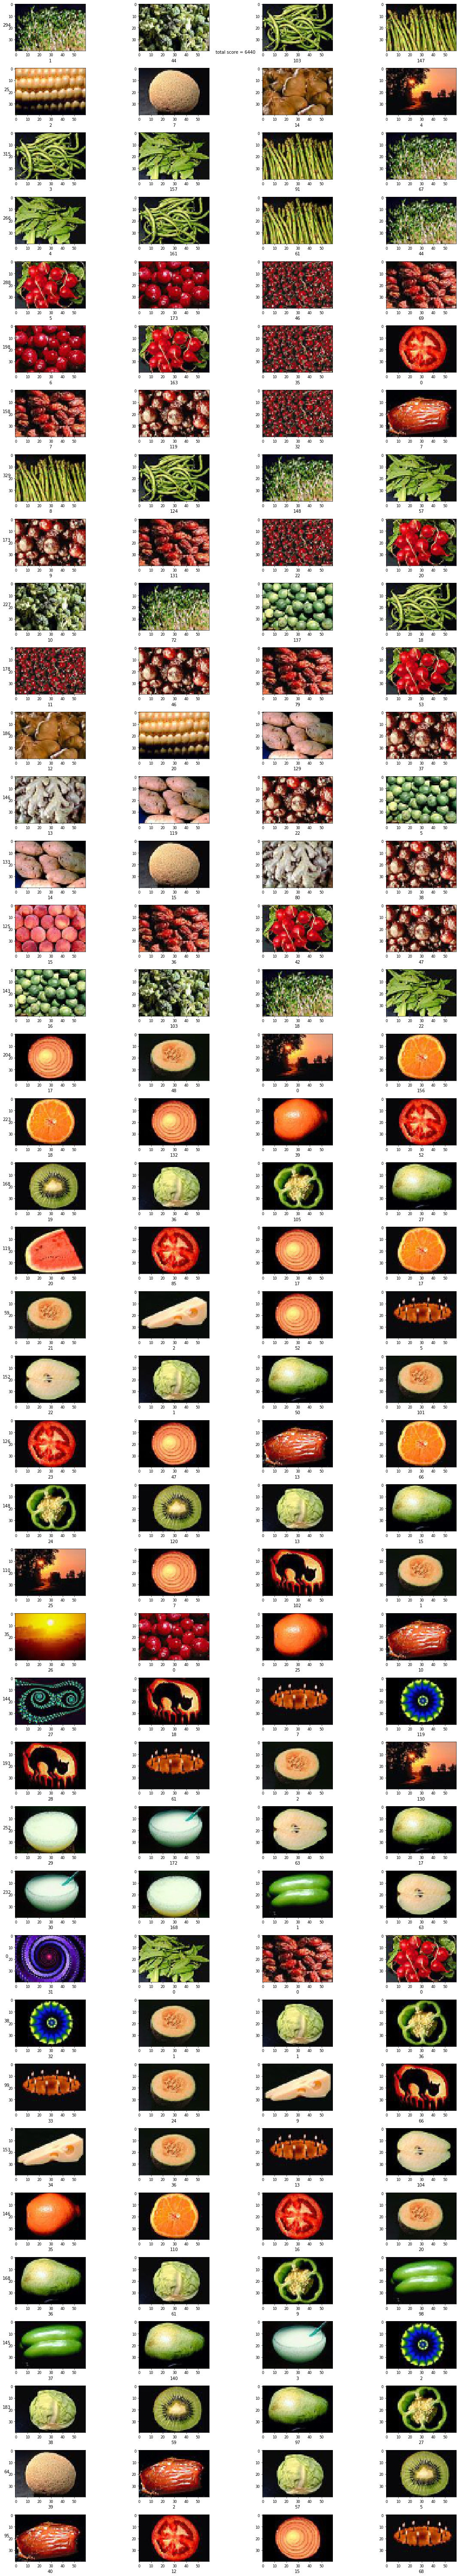

In [28]:
final = closest_three_overall
plt.close("all")
f, grid = plt.subplots(40, 4, figsize=(20, 100), dpi = 60)
col = 0
score_sum = 0
rows = []
for row in range(NUM_IMG):
    thumbnail = cv2.resize(im_list[row], (60,40))
    grid[row, 0].imshow(cv2.cvtColor(thumbnail, cv2.COLOR_BGR2RGB))
    grid[row, 0].set_xlabel(str(row + 1), fontsize = 12)
    score_q_sum = 0
    for i in range(3):
        id = int(final[row][i] - 1)
        thumbnail = cv2.resize(im_list[id], (60,40))
        grid[row, i+1].imshow(cv2.cvtColor(thumbnail, cv2.COLOR_BGR2RGB))
        score = crowd[row][id]
        score_q_sum += score
        grid[row, i+1].set_xlabel(str(score), fontsize = 12)
    # grid[:,row].set_ylabel(str(score_q_sum))
    rows.append(score_q_sum)
    score_sum += score_q_sum
    
for ax, row in zip(grid[:,0], rows):
    ax.set_ylabel(row, rotation=0, size='large', fontsize = 12)
f.tight_layout()
f.suptitle("total score = " + str(score_sum))
f.savefig('./Output/overall.png')

# Total score = 6440

In [29]:
np.savetxt('./Output/dist_matrix_all_' + str(n_bins) + '.txt', overall_distance_matrix, '%.2f')
np.savetxt('./Output/closest_three_all_' + str(n_bins) + '.txt', closest_three_overall, '%2d')

In [30]:
### Personal ground truth versus the system
performance_count = 0
for i in range(NUM_IMG):
    performance_count += np.intersect1d(personal[i][1:4], final[i]).size
print(performance_count)

51


In [32]:
### Find upper bound
sum_max = 0
for i in range(NUM_IMG):
    ids = np.argpartition(crowd[i], -3)[-3:]
    sum_max += np.sum(crowd[i][ids])
print(sum_max)

9680
